# AMPATH Patient & AMPATH Kasha Delivery EDA

### Table of Contents
* [Introduction](#introduction)
* [Ampath Patient Dataset Overview](#ampath-patient-dataset-overview)
  * [Key Information Available](#key-information-available)
  * [Who's Getting HIV Treatment](#whos-getting-hiv-treatment)
  * [Patient Health Status](#patient-health-status)
  * [Time from Diagnosis to Care Entry](#time-from-diagnosis-to-care-entry)
  * [Patient Retention](#patient-retention)
  * [Visit Pattern Analysis](#visit-pattern-analysis)
  * [Appointment Timing Analysis](#appointment-timing-analysis)
  * [CD4 Count Analysis](#cd4-count-analysis)
  * [Monthly Visit Patters (2021-2024)](#monthly-visit-patterns-2021-2024)
  * [Proposed Workflow for POC](#proposed-workflow-for-poc)
* [AMPATH-Kasha Delivery Dataset Overview](#ampath-kasha-delivery-dataset-overview)
   * [Key Information Available](#key-information-available-in-the-dataset)
   * [HIV Patient Distribution by County Analysis](#hiv-patient-distribution-by-county-analysis)
   * [AMPATH ART Medication Deliveries over the Past Year](#ampath-art-medication-deliveries-over-the-past-year)
   * [Expected Next ART Medication Delivery Dates](#expected-next-art-medication-delivery-dates)
* [Comparison Between the AMPATH Patients Dataset vs AMPATH Kasha Delivery Dataset](#comparison-between-the-ampath-patients-dataset-vs-ampath-kasha-delivery-dataset)
  * [Gender Distribution Analysis - AMPATH Patients & AMPATH Kasha Delivery](#gender-distribution-analysis---ampath-patients--ampath-kasha-delivery)
  * [Age Distribution Analysis- AMPATH Patients](#age-distribution-analysis---ampath-patient-dataset)
  * [Age at First Diagnosis - AMPATH Patients](#age-at-first-diagnosis---ampath-patient-dataset)
  * [Age Distribution Analysis - AMPATH Kasha Delivery](#age-range-distribution-analysis---ampath-kasha-delivery-dataset)
* [Appendix](#appendix)
  * [Appendix A: Long Gaps between Visits](#appendix-a-long-gaps-between-visits)
  * [Appendix B: HIV Patient Registration Date Distribution Analysis](#appendix-b-hiv-patient-registration-distribution)
   

## Introduction
This EDA uses HIV patient data from two sources:
 - **Ampath Patient dataset** - This is patient data collected over multiple years, containing **1.89 million** visit records from the clinic. Each record captures important information about a patient's visit and health status.
 - **Ampath-Kasha Delivery dataset** - This is patient data collected over the past one year containing over **1,000** records in Microsoft Dynamics 365 Business Central, extracted via an API integration with AMPATH. The dataset provides comprehensive insights into patient demographics, medication type (ART), and delivery logistics.
  
#### Purpose:
The purpose of this EDA is to analyze the HIV patient data from the two sources, identify key insights, gaps and anomalies and raise questions to make better business decisions.
This also serves as a base to show that AI/ML models can be built which can be used for predictions for use cases such as delivery timings and patient adherence.

In [1]:
! pip install -q pandas numpy matplotlib seaborn openpyxl


[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.dates import DateFormatter
import warnings

warnings.filterwarnings("ignore")

plt.rcParams.update(
    {
        "font.size": 12,
        "axes.titlesize": 16,
        "axes.titleweight": "bold",
        "axes.labelweight": "bold",
        "axes.labelsize": 12,
        "xtick.labelsize": 10,
        "ytick.labelsize": 10,
        "figure.facecolor": "#F0F0F0",
        "axes.facecolor": "#F0F0F0",
        "figure.titlesize": 18,
        "axes.axisbelow": True,
    }
)

In [3]:
def read_file_ampath(file_path, sheet_name=0):
    """Reads data from an Excel or CSV file."""
    if file_path.endswith(".csv"):
        return pd.read_csv(file_path)
    elif file_path.endswith((".xls", ".xlsx")):
        return pd.read_excel(file_path, sheet_name=sheet_name)
    else:
        raise ValueError(
            "Unsupported file format. Please provide an Excel or CSV file."
        )

def read_file_ampath_patient():
    return pd.read_csv("data/LTFU_data.csv")

### Ampath Patient Dataset Overview
This analysis uses HIV patient data collected over multiple years, containing **1.89 million** visit records from the clinic. Each record captures important information about a patient's visit and health status.

In [4]:
# Display basic information about the dataset
print("\nDataset Info:")
print("-" * 50)

df = read_file_ampath_patient()
df.info()


Dataset Info:
--------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1891863 entries, 0 to 1891862
Data columns (total 21 columns):
 #   Column                          Dtype 
---  ------                          ----- 
 0   patient_identifier              object
 1   person_id                       int64 
 2   gender                          object
 3   birthdate                       object
 4   Encounter_Date                  object
 5   height                          object
 6   weight                          object
 7   Next_clinical_appointment       object
 8   Diagnosis_Date                  object
 9   Tuberculosis_Treatment_Plan     int64 
 10  Current_WHO_HIV_Stage           object
 11  CD4_Count                       object
 12  Is_ART                          object
 13  Is_PMTCT                        object
 14  Viral_Load                      object
 15  Adherence                       object
 16  Education_Level         


![Ampath Patients](images/patient_data.png)

#### Key Information Available
- **Patient Details**: Basic information like gender and age
- **Visit Information**: Dates of clinic visits and next appointments
- **Health Indicators**: 
  - WHO HIV stage
  - CD4 count
  - Viral load measurements
- **Treatment Status**: 
  - HIV medication (ART) status
  - Other preventive treatments
- **Care Monitoring**:
  - Treatment adherence
  - Follow-up appointments
  - Height and weight measurements




### Who's Getting HIV Treatment
This chart shows the number of patients on HIV treatment (ART).



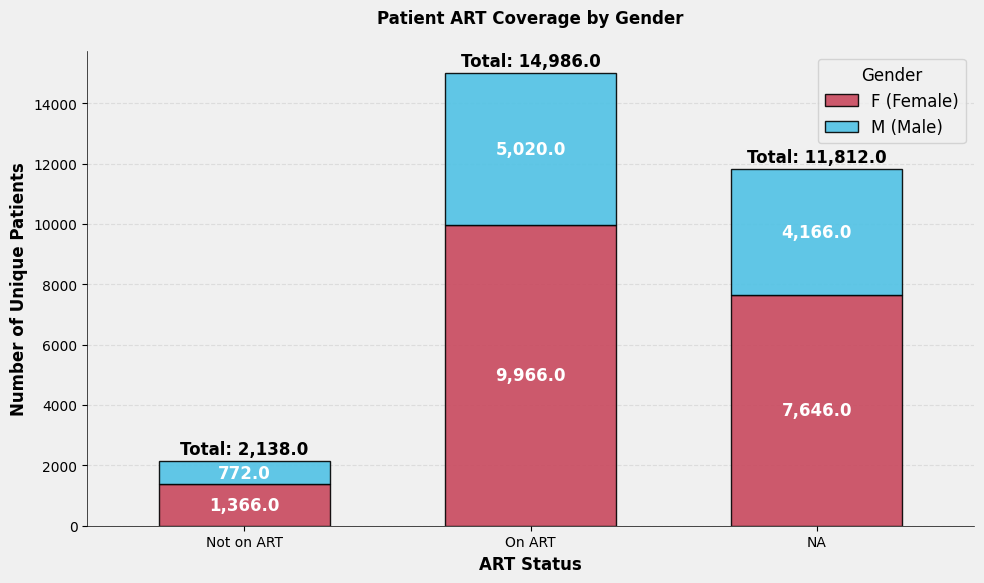

In [5]:
# Clean gender data and get the last known ART status for each patient
art_gender_data = (
    df.groupby(["patient_identifier", "gender"])["Is_ART"]
    .last()  # Get most recent ART status
    .reset_index()
    .pivot_table(index="Is_ART", columns="gender", aggfunc="size", fill_value=0)
)

# Rename ART status categories for clarity
art_gender_data = art_gender_data.rename(
    index={"1": "On ART", "0": "Not on ART", "\\N": "NA"}
)

# Add total counts for each ART category
art_gender_data["Total"] = art_gender_data.sum(axis=1)

# Calculate percentages for each gender within each ART category
art_gender_data["F (%)"] = (art_gender_data["F"] / art_gender_data["Total"]) * 100
art_gender_data["M (%)"] = (art_gender_data["M"] / art_gender_data["Total"]) * 100

# Create the visualization
plt.figure(figsize=(10, 6))

# Create a vertical stacked bar plot
bar_width = 0.6
ax = art_gender_data[["F", "M"]].plot(
    kind="bar",
    stacked=True,
    color=["#C9495E", "#50C2E5"],
    alpha=0.9,
    edgecolor="black",
    linewidth=1,
    width=bar_width,
    ax=plt.gca(),
)

# Add data labels inside the bars
for i, (index, row) in enumerate(art_gender_data.iterrows()):
    f_count = row["F"]
    m_count = row["M"]
    total_count = row["Total"]
    plt.text(
        i,
        f_count / 2,
        f"{f_count:,}",
        ha="center",
        va="center",
        color="white",
        fontweight="bold",
    )
    plt.text(
        i,
        f_count + m_count / 2,
        f"{m_count:,}",
        ha="center",
        va="center",
        color="white",
        fontweight="bold",
    )
    plt.text(
        i,
        total_count + 100,
        f"Total: {total_count:,}",
        ha="center",
        va="bottom",
        fontweight="bold",
    )

# Customize the plot
plt.title("Patient ART Coverage by Gender", pad=20, fontsize=12, fontweight="bold")
plt.xlabel("ART Status")
plt.ylabel("Number of Unique Patients")
plt.xticks(rotation=0)
plt.legend(title="Gender", labels=["F (Female)", "M (Male)"], loc="upper right")

# Disable vertical gridlines and adjust spines
ax.grid(axis="y", linestyle="--", alpha=0.3)  # Keep only horizontal gridlines
ax.grid(axis="x", visible=False)  # Disable vertical gridlines
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["left"].set_linewidth(0.5)
ax.spines["bottom"].set_linewidth(0.5)

plt.tight_layout()

# Show the plot
plt.show()

#### What the Data Shows
Half of the patients (51.8%) are currently on ART. Treatment data is missing for many patients. Better record-keeping is needed to ensure all eligible patients receive treatment.

#### Questions:
**1. Despite being HIV patients, why are more than 2,000 patients not on ART?** <br>
**2. What are the gaps in the current data entry systems that failed to capture information for almost half of the patients?**

### Patient Health Status
This chart shows the severity of HIV infection in patients based on WHO stages, from Stage 1 (least severe) to Stage 4 (most severe).


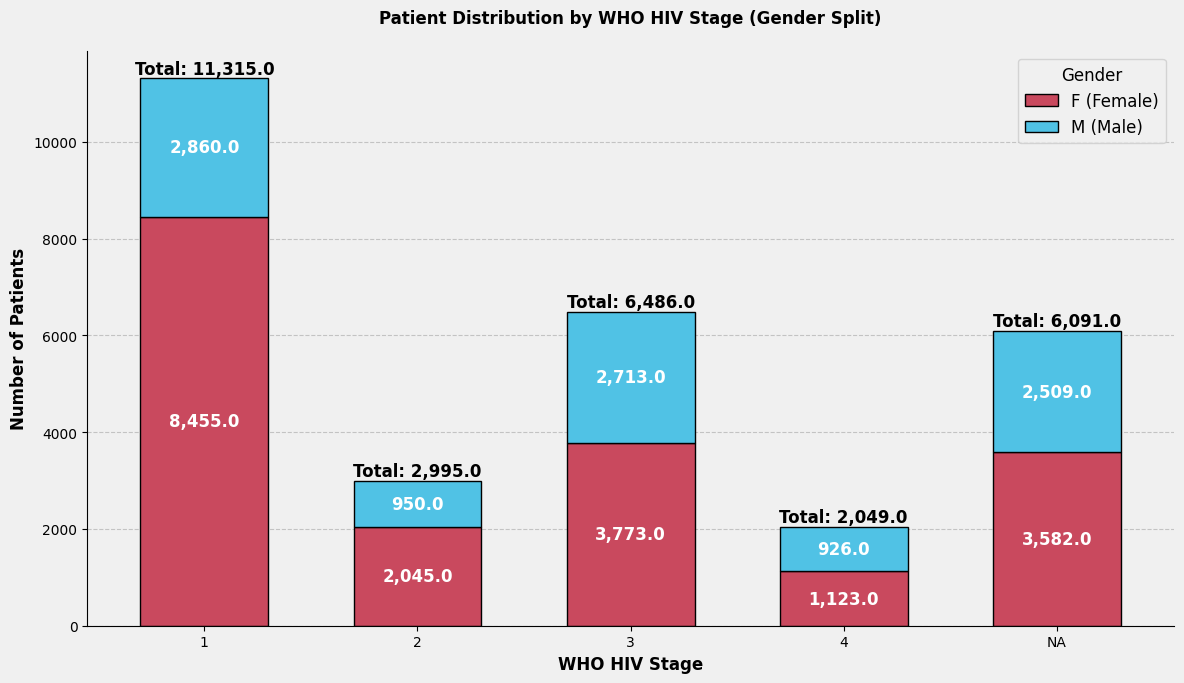

In [6]:

def get_patient_stage_info(df):
    # Convert Encounter_Date to datetime (though you're already doing this before)
    df["Encounter_Date"] = pd.to_datetime(df["Encounter_Date"], errors="coerce")
    
    # Sort by date and take the latest entry for each patient
    latest_stages = (df.sort_values('Encounter_Date')
                      .groupby(['patient_identifier', 'gender'])
                      .last()
                      .reset_index())
    
    # Clean invalid stages
    latest_stages.loc[latest_stages['Current_WHO_HIV_Stage'] == '\\N', 'Current_WHO_HIV_Stage'] = 'NA'
    latest_stages.loc[latest_stages['Current_WHO_HIV_Stage'].isna(), 'Current_WHO_HIV_Stage'] = 'NA'
    
    return latest_stages[['patient_identifier', 'gender', 'Current_WHO_HIV_Stage']]

# Clean and pivot data
clean_stages = get_patient_stage_info(df)
pivot_data = (clean_stages.groupby(['Current_WHO_HIV_Stage', 'gender'])
              .size()
              .unstack(fill_value=0)
              .rename_axis(index='WHO Stage', columns='Gender'))

# Add totals and percentages
pivot_data['Total'] = pivot_data.sum(axis=1)
pivot_data['F (%)'] = (pivot_data['F'] / pivot_data['Total']) * 100
pivot_data['M (%)'] = (pivot_data['M'] / pivot_data['Total']) * 100

# Plot gender-split bars
plt.figure(figsize=(12, 7))
bar_width = 0.6
pivot_data[['F', 'M']].plot(kind='bar', stacked=True,
                            color=['#C9495E', '#50C2E5'],
                            edgecolor='black',
                            linewidth=1,
                            width=bar_width, ax=plt.gca())

# Add data labels inside bars
for i, (index, row) in enumerate(pivot_data.iterrows()):
    f_count = row['F']
    m_count = row['M']
    total_count = row['Total']
    plt.text(i, f_count / 2, f'{f_count:,}', ha='center', va='center', color='white', fontweight='bold')
    plt.text(i, f_count + m_count / 2, f'{m_count:,}', ha='center', va='center', color='white', fontweight='bold')
    plt.text(i, total_count + 10, f'Total: {total_count:,}', ha='center', va='bottom', fontweight='bold')

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Customize plot
plt.title('Patient Distribution by WHO HIV Stage (Gender Split)', pad=20, fontsize=12, fontweight='bold')
plt.xlabel('WHO HIV Stage')
plt.ylabel('Number of Patients')
plt.xticks(rotation=0)
plt.legend(title='Gender', labels=['F (Female)', 'M (Male)'], loc='upper right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

# Show plot
plt.show()



#### What the Data Shows
The data reveals that among patients with recorded WHO stages:
- 50.9% (14,745) are in Stage 1, showing early disease management
- 5.2% (1,492) are in Stage 2
- 15.1% (4,376) are in Stage 3, requiring increased attention
- 7.8% (2,270) are in Stage 4, needing urgent care
- 20.9% (6,053) have no stage recorded

The high number of Stage 1 patients suggests good early detection. However, the significant number of patients with no recorded stage indicates a need for better documentation. 

#### Questions:
**1. What are the factors that result in more than 6,000 patients not having their HIV stages recorded?**

### Time from Diagnosis to Care Entry
These visualizations show how quickly patients enter clinical care after their HIV diagnosis, with data filtered between 2000-2025.

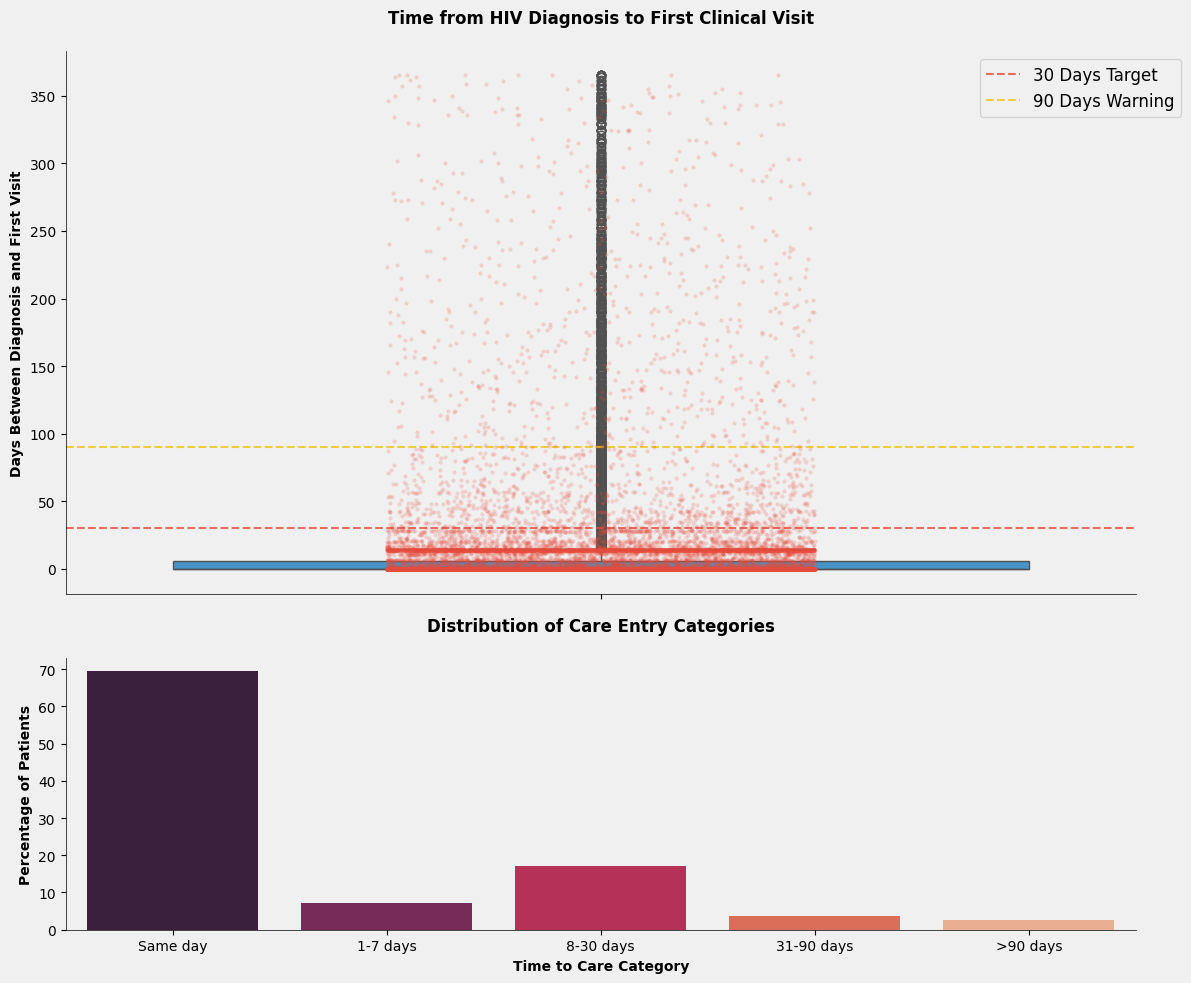

In [7]:
# Convert dates to datetime
df["Diagnosis_Date"] = pd.to_datetime(df["Diagnosis_Date"], errors="coerce")
df["Encounter_Date"] = pd.to_datetime(df["Encounter_Date"], errors="coerce")

# Get first visit for each patient with date range filters
first_visits = (
    df[
        (df["Diagnosis_Date"] >= "2000-01-01")
        & (df["Diagnosis_Date"] <= pd.Timestamp.now())
        & (df["Encounter_Date"] >= "2000-01-01")
        & (df["Encounter_Date"] <= pd.Timestamp.now())
    ]
    .groupby("patient_identifier")
    .agg({"Diagnosis_Date": "min", "Encounter_Date": "min"})
    .reset_index()
)

# Calculate days between diagnosis and first visit
first_visits["days_to_care"] = (
    first_visits["Encounter_Date"] - first_visits["Diagnosis_Date"]
).dt.days

# Filter for realistic timeframes and remove negative intervals
first_visits = first_visits[
    (first_visits["days_to_care"] >= 0)
    & (first_visits["days_to_care"] <= 365)  # Limit to 1 year
]

# Create categories for analysis
first_visits["care_entry_category"] = pd.cut(
    first_visits["days_to_care"],
    bins=[-float("inf"), 0, 7, 30, 90, float("inf")],
    labels=["Same day", "1-7 days", "8-30 days", "31-90 days", ">90 days"],
)

# Create figure with two subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10), height_ratios=[2, 1])

# Plot 1: Distribution of days to care
sns.boxplot(y=first_visits["days_to_care"], ax=ax1, color="#3498db")
sns.stripplot(
    y=first_visits["days_to_care"],
    ax=ax1,
    color="#e74c3c",
    alpha=0.2,
    size=3,
    jitter=0.2,
)

# Remove box for first plot
ax1.spines["top"].set_visible(False)
ax1.spines["right"].set_visible(False)
ax1.spines["left"].set_linewidth(0.5)
ax1.spines["bottom"].set_linewidth(0.5)

# Add reference lines
ax1.axhline(y=30, color="#e74c3c", linestyle="--", alpha=0.8, label="30 Days Target")
ax1.axhline(y=90, color="#f1c40f", linestyle="--", alpha=0.8, label="90 Days Warning")
ax1.set_title(
    "Time from HIV Diagnosis to First Clinical Visit",
    pad=20,
    fontsize=12,
    fontweight="bold",
)
ax1.set_ylabel("Days Between Diagnosis and First Visit", fontsize=10)
ax1.legend(bbox_to_anchor=(1.05, 1))

# Plot 2: Category distribution
category_counts = first_visits["care_entry_category"].value_counts()
category_percentages = category_counts / len(first_visits) * 100

sns.barplot(
    x=category_percentages.index,
    y=category_percentages.values,
    ax=ax2,
    palette="rocket",
)

# Remove box for second plot
ax2.spines["top"].set_visible(False)
ax2.spines["right"].set_visible(False)
ax2.spines["left"].set_linewidth(0.5)
ax2.spines["bottom"].set_linewidth(0.5)

ax2.set_title(
    "Distribution of Care Entry Categories", pad=20, fontsize=12, fontweight="bold"
)
ax2.set_xlabel("Time to Care Category", fontsize=10)
ax2.set_ylabel("Percentage of Patients", fontsize=10)

plt.tight_layout()
plt.show()

#### What the Data Shows:
The data reveals the following:
 - A high percentage (69.4%) of patients enter into the program on the same day of diagnosis
 - The majority of patients take less than 30 days to enter the care program from diagnosis
 - Less than 10% of total patients took more than 30 days to enter the care program

#### Questions

**1) Why do we see such a high percentage (69.4%) of same-day entries? Is this a data entry issue or the program is well conducted to treat the patients on the day of diagnosis?**

**2) For patients taking >30 days, what barriers are preventing earlier care entry?**



### Patient Retention 

How long are patients typically staying in the program?

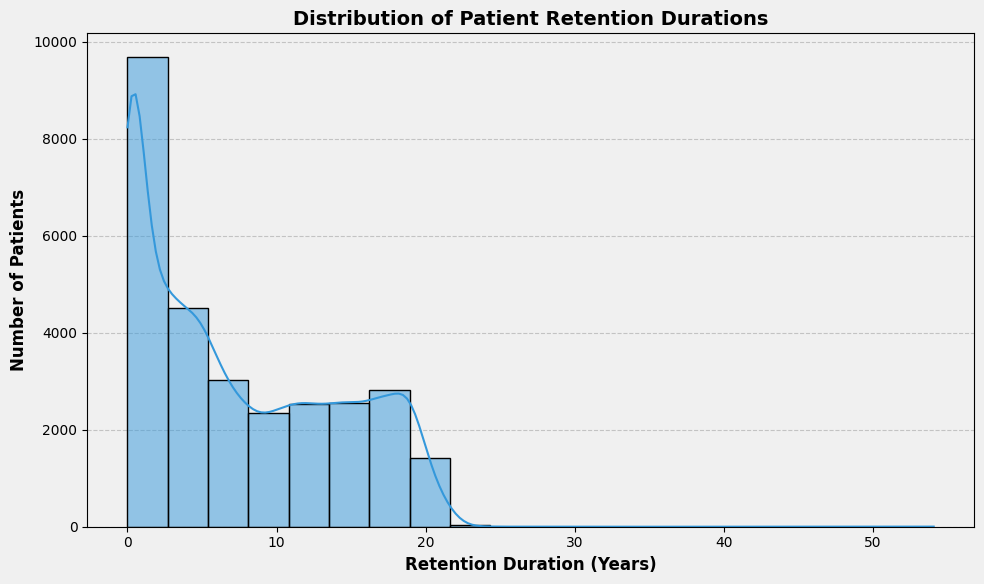

In [8]:
# Calculate retention duration
df["first_visit"] = df.groupby("patient_identifier")["Encounter_Date"].transform("min")
df["last_visit"] = df.groupby("patient_identifier")["Encounter_Date"].transform("max")
df["retention_years"] = (df["last_visit"] - df["first_visit"]).dt.days / 365.25

# Aggregate unique patient data
unique_patients = df.drop_duplicates(subset="patient_identifier", keep="first")

# Plot histogram for retention years
plt.figure(figsize=(10, 6))
sns.histplot(unique_patients["retention_years"], bins=20, kde=True, color="#3498db")
plt.title("Distribution of Patient Retention Durations", fontsize=14, fontweight="bold")
plt.xlabel("Retention Duration (Years)", fontsize=12)
plt.ylabel("Number of Patients", fontsize=12)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

#### What the Data Shows:
The patient retention data shows the following:
 - The retention rate is highest in the 1-3 year range, with a significant drop-off after
 - The longest retention rate is slightly more than 20 years

#### Questions:
**1. What are the common reasons for majority of the patients leaving the program after less than 3 years?**

### Visit Pattern Analysis
This heatmap shows when patients visit the clinic throughout a typical week, focusing on working hours from 7 AM to 6 PM.

Cleaned date range:
Earliest date: 2000-01-15 00:00:00
Latest date: 2024-10-20 00:00:00

Removed 10 invalid or future dates


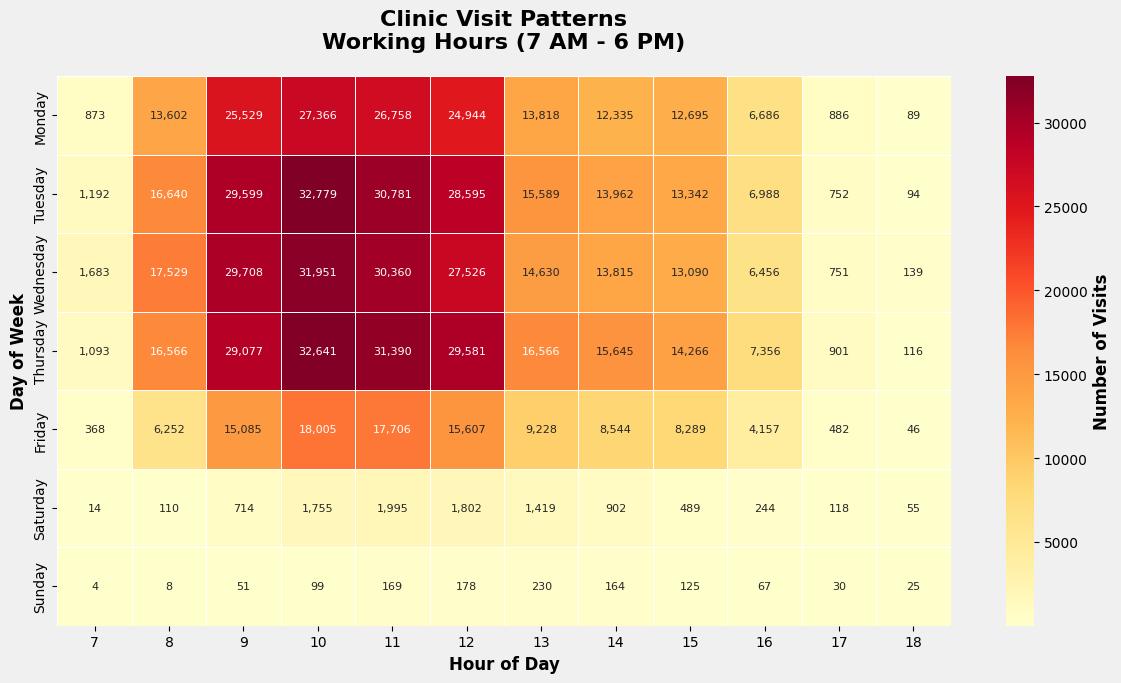

In [9]:
# Convert Encounter_Date to datetime and handle invalid dates
df["Encounter_Date"] = pd.to_datetime(df["Encounter_Date"], errors="coerce")

# Filter out future dates and very old dates (before 2000)
df_valid = df[
    (df["Encounter_Date"] <= pd.Timestamp.now())
    & (df["Encounter_Date"] >= pd.Timestamp("2000-01-01"))
]

print("Cleaned date range:")
print("Earliest date:", df_valid["Encounter_Date"].min())
print("Latest date:", df_valid["Encounter_Date"].max())
print(f"\nRemoved {len(df) - len(df_valid)} invalid or future dates")


# For the visit pattern analysis, let's use only valid dates
df_valid = df.dropna(subset=["Encounter_Date"])

# Extract day and hour info
df_valid["day_of_week"] = df_valid["Encounter_Date"].dt.day_name()
df_valid["hour_of_day"] = df_valid["Encounter_Date"].dt.hour
# Calculate visit frequency by day and hour
visit_patterns = (
    df_valid.groupby(["day_of_week", "hour_of_day"]).size().unstack(fill_value=0)
)

# Reorder days for better visualization
days_order = [
    "Monday",
    "Tuesday",
    "Wednesday",
    "Thursday",
    "Friday",
    "Saturday",
    "Sunday",
]
visit_patterns = visit_patterns.reindex(days_order)

# Filter to show only clinic hours (7-18)
visit_patterns = visit_patterns.loc[:, 7:18]

# Create heatmap with improved styling
plt.figure(figsize=(12, 7))
sns.heatmap(
    visit_patterns,
    cmap="YlOrRd",
    annot=True,
    fmt=",d",  # Format numbers with comma separator
    annot_kws={"size": 8},  # Smaller font for numbers
    cbar_kws={"label": "Number of Visits"},
    linewidths=0.5,
)

plt.title("Clinic Visit Patterns\nWorking Hours (7 AM - 6 PM)", pad=20)
plt.xlabel("Hour of Day")
plt.ylabel("Day of Week")
plt.tight_layout()
plt.show()


#### What the Data Shows
The visit patterns reveal clear operational insights:
- Peak hours are between 9 AM and 12 PM across weekdays
- Highest patient traffic occurs on Tuesdays and Thursdays (around 32,000 visits at 10 AM)
- Friday shows lower traffic compared to other weekdays
- Weekend visits are minimal (less than 2,000 visits even at peak hours)
- Morning slots (9 AM - 12 PM) handle 60% of daily patient volume
- After 4 PM, patient visits drop significantly

**This information can help optimize staffing levels and clinic resources based on peak times.**

#### Questions:
**1. Why are patient visits highest between 9 AM and 12 PM? Is it due to patient preferences, clinic scheduling policies, or external factors?** <br>
**2. Why do weekdays experience the highest patient traffic? Are these preferred appointment days, or do clinic policies influence this pattern?** <br>
**3. What are the reasons behind minimal weekend visits?**


### Appointment Timing Analysis
This graph shows when patients come for their visits compared to their scheduled appointment dates. The green line marks perfect timing (coming exactly on the scheduled day) and blue lines show a 3-day early/late window.

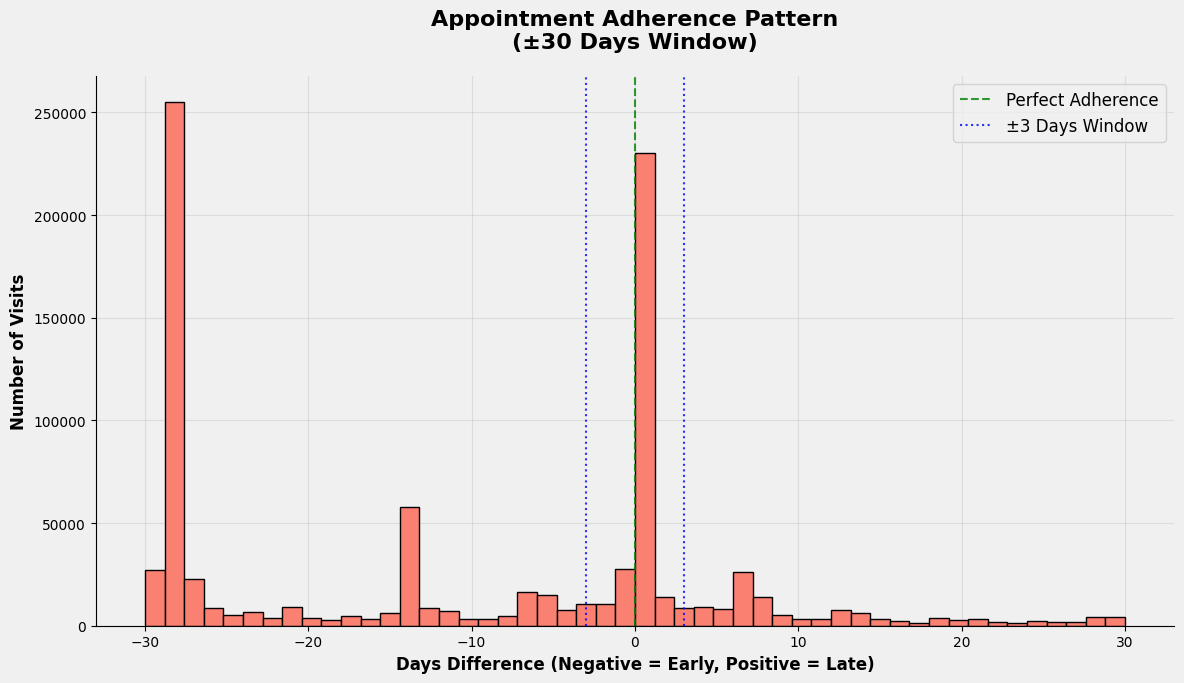

In [10]:
# Ensure dates are in datetime format and filter to valid date range
df["Next_clinical_appointment"] = pd.to_datetime(
    df["Next_clinical_appointment"], errors="coerce"
)

# Calculate days difference between scheduled and actual visits
df_valid = df[
    (df["Encounter_Date"] <= pd.Timestamp.now())
    & (df["Encounter_Date"] >= pd.Timestamp("2000-01-01"))
]

# Calculate difference in days
df_valid["days_difference"] = (
    df_valid["Encounter_Date"] - df_valid["Next_clinical_appointment"]
).dt.days

# Create histogram of appointment adherence
plt.figure(figsize=(12, 7))
plt.hist(
    df_valid["days_difference"].dropna(),
    bins=50,
    range=(-30, 30),  # Focus on ±30 days
    edgecolor="black",
    color="salmon",
)
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)

# Add vertical lines for reference
plt.axvline(x=0, color="green", linestyle="--", alpha=0.8, label="Perfect Adherence")
plt.axvline(x=-3, color="blue", linestyle=":", alpha=0.8, label="±3 Days Window")
plt.axvline(x=3, color="blue", linestyle=":", alpha=0.8)

plt.title("Appointment Adherence Pattern\n(±30 Days Window)", pad=20)
plt.xlabel("Days Difference (Negative = Early, Positive = Late)")
plt.ylabel("Number of Visits")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()



#### What the Data Shows
Looking at the visit patterns:
- A large spike appears at -30 days (250,000 visits), suggesting many patients come a month early
- Another significant peak at day 0 (220,000 visits) shows many patients come exactly on time
- Smaller peaks at +10 days show late visits
- The pattern between -3 and +3 days (blue dotted lines) shows regular attendance
- Fewer visits occur beyond 15 days late

**This data suggests most patients either come exactly on time or very early. The early visits need investigation as they might indicate data recording issues or appointment rescheduling patterns.**

#### Questions:
**1. What factors contribute to the high number of patients attending exactly on time?** <br>
**2. What factors contribute to the high number of patients attending earlier than scheduled time?**

### CD4 Count Analysis
This graph shows CD4 counts (a key measure of immune system health) across different patient visit patterns. Higher CD4 counts indicate better health status.


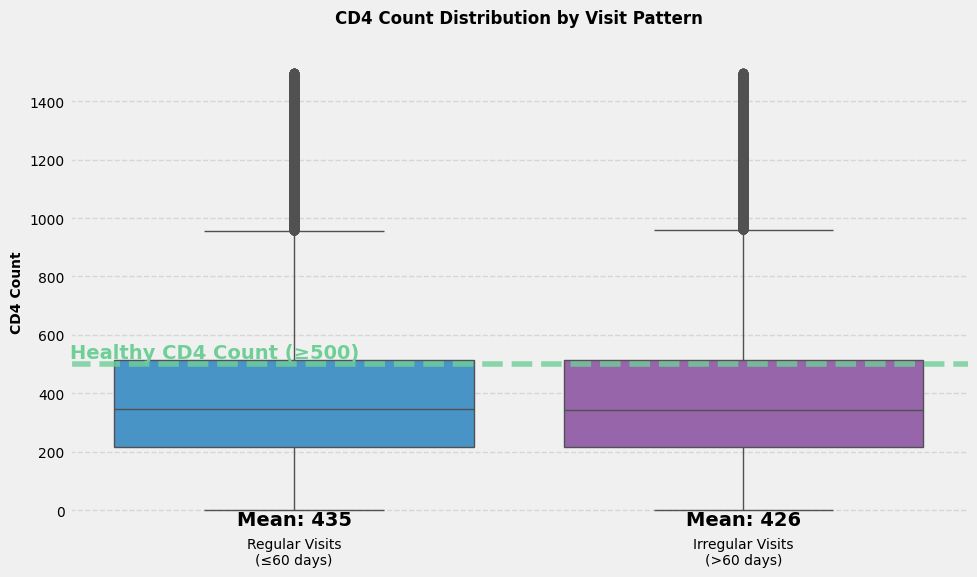

In [23]:
# Convert dates to datetime and CD4 to numeric
df["Encounter_Date"] = pd.to_datetime(df["Encounter_Date"], errors="coerce")
df["CD4_Count"] = pd.to_numeric(df["CD4_Count"], errors="coerce")

# Filter for valid CD4 and date data
df_valid_cd4 = df[df["CD4_Count"].notna() & df["Encounter_Date"].notna()]

# Calculate days between visits
df_valid_cd4 = df_valid_cd4.sort_values(["patient_identifier", "Encounter_Date"])
df_valid_cd4["days_to_next_visit"] = (
    df_valid_cd4.groupby("patient_identifier")["Encounter_Date"]
    .diff()
    .shift(-1)
    .dt.days
)

# Add cutoff date (90 days before last date in dataset)
last_date = df_valid_cd4["Encounter_Date"].max()
cutoff_date = last_date - pd.Timedelta(days=90)

# Filter data and categorize visits
df_analysis = df_valid_cd4[df_valid_cd4["Encounter_Date"] <= cutoff_date]
df_analysis["visit_category"] = df_analysis["days_to_next_visit"].apply(
    lambda x: (
        "Regular Visits\n(≤60 days)"
        if pd.notnull(x) and x <= 60
        else "Irregular Visits\n(>60 days)"
    )
)

# Create visualization
plt.figure(figsize=(10, 6))

# Create box plot
sns.boxplot(
    data=df_analysis[df_analysis["CD4_Count"] < 1500],
    x="visit_category",
    y="CD4_Count",
    palette=["#3498db", "#9b59b6"],
)
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)

# Add reference line for healthy CD4 count
plt.axhline(y=500, color='#6FCF97', linestyle='--', alpha=0.8)
plt.text(-0.5, 520, 'Healthy CD4 Count (≥500)', color='#6FCF97', fontweight='bold')

# Add mean values as text
for i, category in enumerate(df_analysis["visit_category"].unique()):
    mean_cd4 = df_analysis[df_analysis["visit_category"] == category][
        "CD4_Count"
    ].mean()
    plt.text(i, -50, f"Mean: {mean_cd4:,.0f}", ha="center", fontweight="bold")

plt.title(
    "CD4 Count Distribution by Visit Pattern", pad=20, fontsize=12, fontweight="bold"
)
plt.xlabel("")
plt.ylabel("CD4 Count", fontsize=10)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()


#### What the Data Shows

- Healthy person has around 500 - 1500 
- The CD4 count analysis shows a small but notable difference between groups, with regular visitors (≤60 days) maintaining a slightly higher average CD4 count (435) compared to irregular visitors (426). 
- This 9-point difference, suggest that regular clinic attendance has a small positive impact on immune system health. 
- This metric is not a strong indicator for indicating LTFU.

#### Question:
**1. What factors other than clinic attendance can explain the CD4 count variations?**

### Monthly Visit Patterns (2021-2024)
This graph shows how clinic visits change throughout each year. By comparing multiple years, we can spot regular patterns and unusual changes in patient attendance.


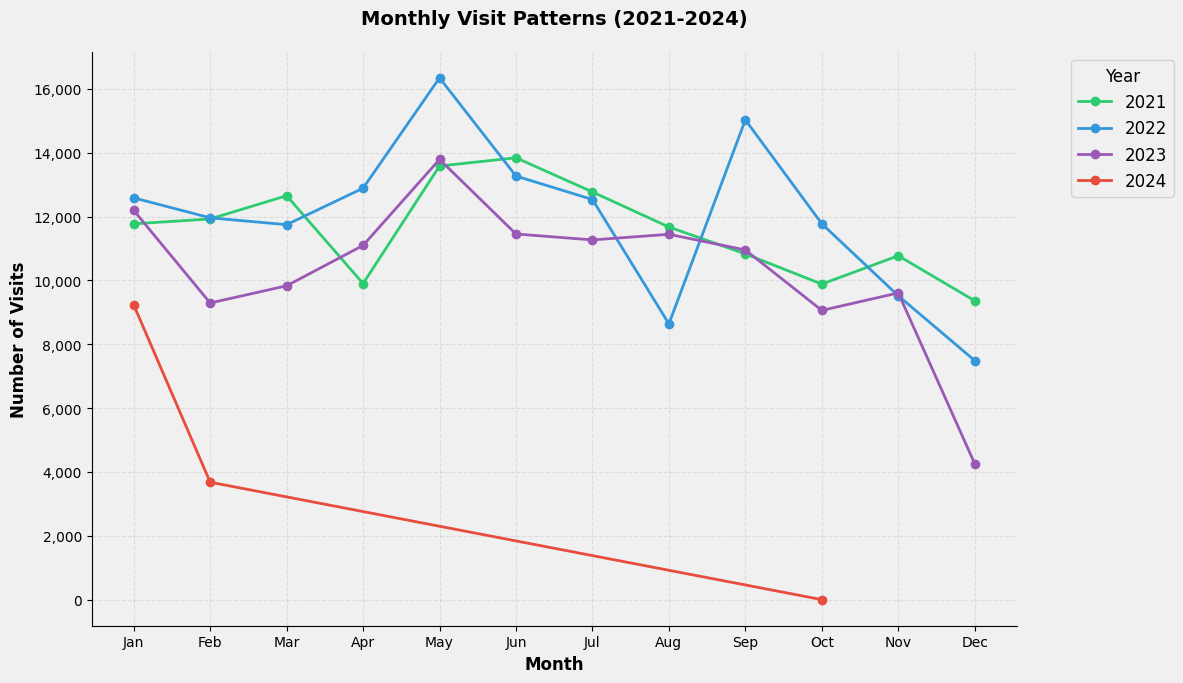

In [12]:
# Ensure Encounter_Date is in datetime format
df["Encounter_Date"] = pd.to_datetime(df["Encounter_Date"], errors="coerce")

# Filter data for the years 2021 to 2024
df_filtered = df[
    (df["Encounter_Date"] >= "2021-01-01") & (df["Encounter_Date"] <= "2024-12-31")
]

# Extract year and month for grouping
df_filtered["year"] = df_filtered["Encounter_Date"].dt.year
df_filtered["month"] = df_filtered["Encounter_Date"].dt.month

# Group by year and month to count visits
monthly_visits = (
    df_filtered.groupby(["year", "month"]).size().reset_index(name="visit_count")
)

# Create the plot
plt.figure(figsize=(12, 7))

# Define professional colors for each year
colors = ["#2ecc71", "#3498db", "#9b59b6", "#e74c3c"]  # Green, Blue, Purple, Red
years = [2021, 2022, 2023, 2024]

# Plot each year
for year, color in zip(years, colors):
    year_data = monthly_visits[monthly_visits["year"] == year]
    plt.plot(
        year_data["month"],
        year_data["visit_count"],
        marker="o",
        linewidth=2,
        color=color,
        label=str(year),
    )

# Customize the plot
plt.title("Monthly Visit Patterns (2021-2024)", pad=20, fontsize=14, fontweight="bold")
plt.xlabel("Month", fontsize=12)
plt.ylabel("Number of Visits", fontsize=12)

# Set x-axis ticks to show all months
plt.xticks(
    range(1, 13),
    [
        "Jan",
        "Feb",
        "Mar",
        "Apr",
        "May",
        "Jun",
        "Jul",
        "Aug",
        "Sep",
        "Oct",
        "Nov",
        "Dec",
    ],
    rotation=0,
)

plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)

# Add grid for better readability
plt.grid(True, linestyle="--", alpha=0.3)

# Add legend
plt.legend(title="Year", bbox_to_anchor=(1.05, 1), loc="upper left")

# Format y-axis with comma separator
plt.gca().yaxis.set_major_formatter(lambda x, p: format(int(x), ","))

plt.tight_layout()
plt.show()


#### What the Data Shows
Looking at the monthly patterns:

**Regular Patterns**
- Most years show 12,000-16,000 visits per month
- **Mid-year months (May-September) typically have highest attendance**
- December consistently shows lowest visits in all years

**Year-by-Year Insights**
- 2021: Most stable year with steady visit numbers
- 2022: Highest overall attendance, peaking at 16,000 monthly visits
- 2023: Shows gradual decline in later months
- 2024: Early data available only for January

**Key Concerns**
- **Recent downward trend needs attention**
- December drops might need holiday season strategies
- Year-over-year decline from 2022 to 2023 calls for investigation
- **Need to know if the results for 2024 is a data entry issue or real issue with patient attendance.**

#### Questions:
**1. Is the 2024 data reflecting an actual attendance issue, or is it a data entry gap?**<br>
**2. What strategies can be implemented to boost attendance in December?**<br>
**3. What contributed to the increase in patient visits in 2022 compared to other years?**



### AMPATH-Kasha Delivery Dataset Overview
This analysis is based on patient information available in Microsoft Dynamics 365 Business Central, extracted via an API integration with AMPATH. The dataset has been systematically collected over the past year and currently includes records for over 1,000 patients. To date, more than 400 successful deliveries have been recorded. It is also important to note that all existing patients are scheduled for the ART medication.

In [13]:
print("\nAmpath Patient Dataset Info:")
print("-" * 50)
df_ampath_info = pd.read_csv("data/Patient List.csv")
df_ampath_info.info()


Ampath Patient Dataset Info:
--------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 959 entries, 0 to 958
Data columns (total 31 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Customer No.                 959 non-null    object 
 1   Id                           959 non-null    int64  
 2   System Generated ID          959 non-null    object 
 3   EMR Person Id                959 non-null    int64  
 4   CCC Patient Identifier       959 non-null    object 
 5   prediction_score             959 non-null    float64
 6   First Name                   959 non-null    object 
 7   Last Name                    959 non-null    object 
 8   Facility                     957 non-null    float64
 9   Medication Type              959 non-null    object 
 10  Primary Phone No.            959 non-null    object 
 11  Seconday Phone No.           378 non-null    object 
 1


![AMPATH Patient List](images/patient_list.png)


#### Key Information Available in the dataset:
 - **Patient Demographics:** <br>
   - Full Name <br>
   - Age <br>
   - Gender <br>
   - Contact Information (Phone Number) <br>

 - **Medication Information:** <br> 
   -  Prescribed Medication Type <br>

 - **Delivery Details:** <br>
   - Expected Next Delivery Date <br>
   - Delivery Location including:
   - County <br>
   - Address <br>
   - Nearest Landmark <br>

### HIV Patient Distribution by County Analysis

This analysis examines the distribution of HIV patients across different counties.


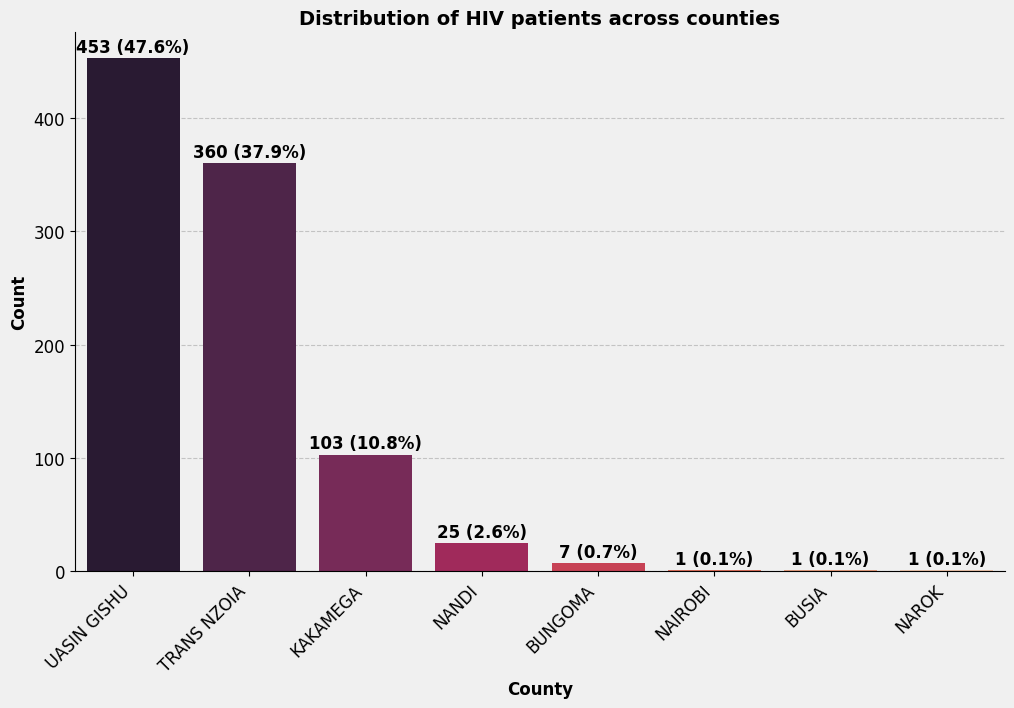

In [14]:
def plot_bar_chart(df_ampath, column, title):
    """Plots a bar chart for patient demographics with total counts and percentages."""
    plt.figure(figsize=(12, 7))
    data = df_ampath[column].value_counts().reset_index()
    data.columns = [column, 'count']

    color_pallette = {
        "NAROK": "#ffadad",
        "KAKAMEGA": "#ffd6a5",
        "BUSIA": "#fdffb6",
        "BUNGOMA": "#caffbf",
        "UASIN GISHU": "#9bf6ff",
        "NAIROBI": "#a0c4ff",
        "NANDI": "#bdb2ff",
        "TRANS NZOIA": "#ffc6ff",
        "SIAYA": "#fffffc",
    }

    ax = sns.barplot(x=column, y='count', hue=column, data=data, dodge=False, legend=False, palette='rocket')

    total_count = data['count'].sum()

    # Customize spines (remove the box look)
    plt.gca().spines["top"].set_visible(False)
    plt.gca().spines["right"].set_visible(False)

    # Adding value labels with percentages
    for p in ax.patches:
        count = int(p.get_height())
        percentage = (count / total_count) * 100
        ax.annotate(f'{count} ({percentage:.1f}%)', 
                    (p.get_x() + p.get_width() / 2, p.get_height() + 2),
                    ha='center', va='bottom', fontsize=12, color='black', fontweight='bold')

    plt.xticks(rotation=45, ha='right', fontsize=12)
    plt.yticks(fontsize=12)
    plt.title(title, fontsize=14, fontweight='bold')
    plt.xlabel(column, fontsize=12, fontweight='bold')
    plt.ylabel('Count', fontsize=12, fontweight='bold')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

if __name__ == "__main__":
    file_path = "data/Patient List.xlsx"
    sheet_name = 0  # Change if needed

    df_ampath = read_file_ampath(file_path, sheet_name)
    plot_bar_chart(df_ampath, "County", "Distribution of HIV patients across counties")


#### What the data shows:
 - All counties apart from Nairobi are located in the Western region of Kenya <br>
 - Uasin Gishu County has the highest number of HIV patients, with 484 individuals, accounting for 48.7% of the total patient population in this dataset.<br>
#### Questions:
**1. What is the regional focus target for Kasha?**<br>

### AMPATH ART Medication Deliveries Over the Past Year

This analysis examines shipment trends for ART (Antiretroviral Therapy) medication across different counties over the past year. 


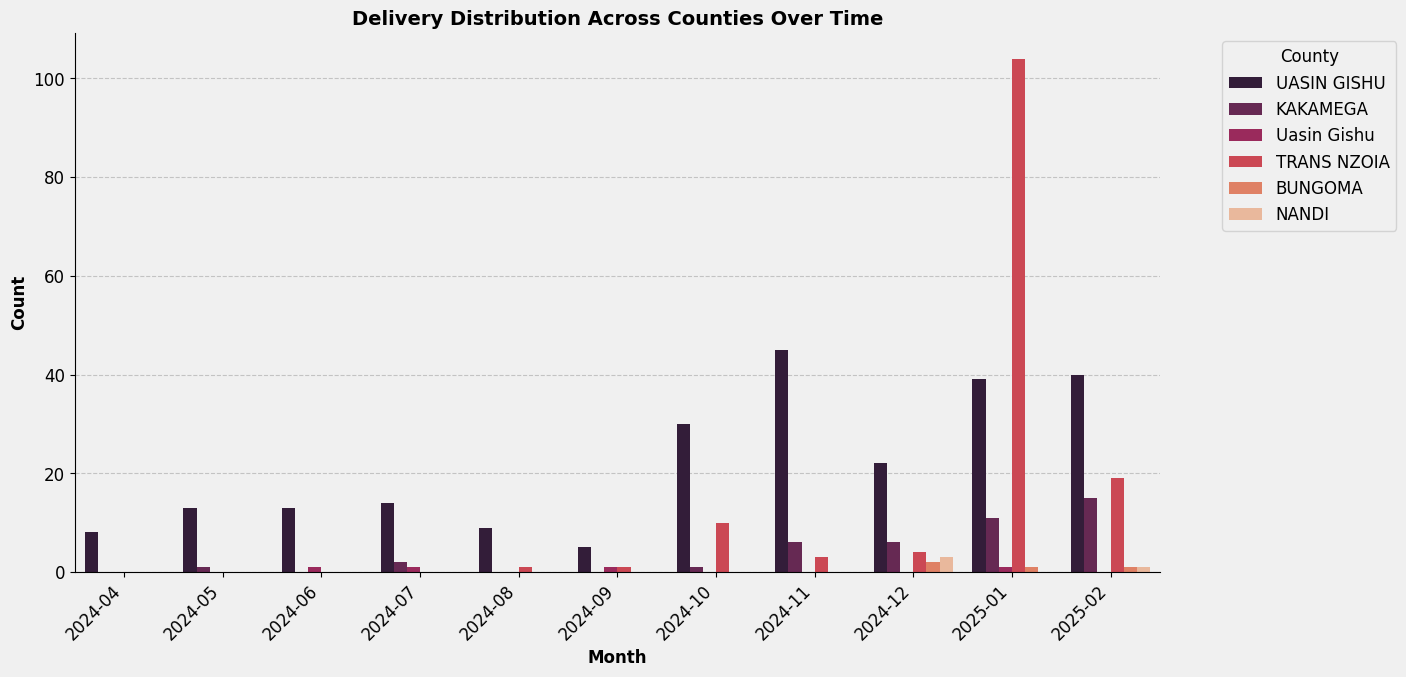

In [15]:
def plot_shipment_by_county_and_month(df_ampath, date_column, county_column):
    """Plots a grouped bar graph showing shipment count per county for each month."""
    df_ampath[date_column] = pd.to_datetime(df_ampath[date_column], errors="coerce")
    df_ampath["Year-Month"] = df_ampath[date_column].dt.to_period("M").astype(str)
    grouped_df = (
        df_ampath.groupby(["Year-Month", county_column])
        .size()
        .reset_index(name="count")
    )

    plt.figure(figsize=(14, 7))

    color_pallette = {
        "NAROK": "#ffadad",
        "KAKAMEGA": "#ffd6a5",
        "BUSIA": "#fdffb6",
        "BUNGOMA": "#caffbf",
        "UASIN GISHU": "#9bf6ff",
        "NAIROBI": "#a0c4ff",
        "NANDI": "#bdb2ff",
        "TRANS NZOIA": "#ffc6ff",
        "SIAYA": "#fffffc",
    }
    
    ax = sns.barplot(x='Year-Month', y='count', hue=county_column, data=grouped_df, dodge=True, palette='rocket')

    # Customize spines (remove the box look)
    plt.gca().spines["top"].set_visible(False)
    plt.gca().spines["right"].set_visible(False)

    plt.xticks(rotation=45, ha='right', fontsize=12)
    plt.yticks(fontsize=12)
    plt.title('Delivery Distribution Across Counties Over Time', fontsize=14, fontweight='bold')
    plt.xlabel('Month', fontsize=12, fontweight='bold')
    plt.ylabel('Count', fontsize=12, fontweight='bold')
    plt.legend(title='County', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()


if __name__ == "__main__":
    file_path = "data/Ampath Deliveries.xlsx"
    sheet_name = 0 

    df_ampath = read_file_ampath(file_path, sheet_name)
    plot_shipment_by_county_and_month(df_ampath, "Shipment Date", "County")

#### What the data shows:
 - Deliveries are being done to counties in the **Western Region** of Kenya based on the current dataset <br>
 - All deliveries are for the **ART** medication at the moment <br>
 - Uasin Gishu recorded the highest ART medication deliveries throughout most months, except for January 2025, when Trans Nzoia led in deliveries.<br>
#### Questions:
  **1. Why do Kakamega, Bungoma, and Nandi have consistently low delivery counts?**<br>
  **2. What are the target counties for delivery coverage for Kasha?** <br>
  **3. Apart from ART medication, what other medication can be delivered to these patients?** <br>

### Expected Next ART Medication Delivery Dates

This analysis examines the projected delivery dates for ART (Antiretroviral Therapy) medication across different counties in the coming months. This Expected Next Delivery Date is updated by Ampath and the same information is transferred to Microsoft Dynamics which is the source of this dataset. 

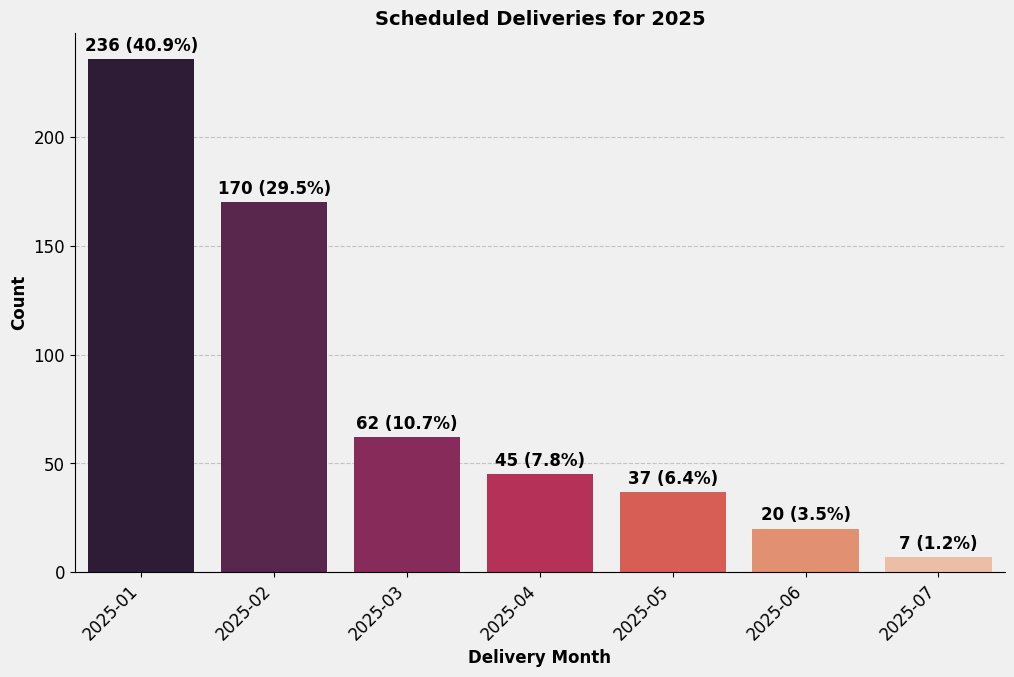

In [16]:
def plot_bar_chart(df_ampath, column, title, order=None):
    """Plots a vertical bar chart for patient demographics with total counts and percentages."""
    plt.figure(figsize=(12, 7))
    data = df_ampath[column].value_counts().reset_index()
    data.columns = [column, 'count'] 

    color_pallette = {
        "2025-01": "#e40b0b",
        "2025-02": "#c30e0e",
        "2025-03": "#a21112",
        "2025-04": "#821415",
        "2025-05": "#611618",
        "2025-06": "#40191c",
        "2025-07": "#1f1c1f",
    }

    ax = sns.barplot(x=column, y='count', hue=column, data=data, dodge=False, legend=False, palette='rocket', order=order if order else data[column])

    total_count = data['count'].sum()

    # Customize spines (remove the box look)
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)

    # Adding value labels with percentages
    for p in ax.patches:
        count = int(p.get_height())
        percentage = (count / total_count) * 100
        ax.annotate(f'{count} ({percentage:.1f}%)', 
                    (p.get_x() + p.get_width() / 2, p.get_height() + 2),
                    ha='center', va='bottom', fontsize=12, color='black', fontweight='bold')

    plt.xlabel(column, fontsize=12, fontweight='bold')
    plt.ylabel('Count', fontsize=12, fontweight='bold')
    plt.xticks(rotation=45, ha='right', fontsize=12)
    plt.yticks(fontsize=12)
    plt.title(title, fontsize=14, fontweight='bold')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()


def plot_expected_delivery_2025(df_ampath, date_column):
    """Plots a vertical bar chart for expected next delivery dates in 2025 grouped by month."""
    df_ampath[date_column] = pd.to_datetime(df_ampath[date_column], errors="coerce")
    df_2025 = df_ampath[
        df_ampath[date_column].dt.year == 2025
    ].copy()  # Explicitly create a copy
    df_2025['Delivery Month'] = df_2025[date_column].dt.to_period('M').astype(str)
    month_order = sorted(df_2025['Delivery Month'].dropna().unique())

    plot_bar_chart(df_2025, 'Delivery Month', 'Scheduled Deliveries for 2025', order=month_order)


if __name__ == "__main__":
    file_path = "data/Patient List.xlsx"
    sheet_name = 0  # Change if needed

    df_ampath = read_file_ampath(file_path, sheet_name)
    plot_expected_delivery_2025(df_ampath, "Expected Next Delivery Date")

#### What the data shows:
 - All scheduled deliveries are for the **ART** medication at the moment <br>
 - The number of expected deliveries is progressively reducing, unlike January and February 2025, which recorded high volumes of projected deliveries. <br>

**The current dataset contains deliveries for ART medication only. We currently do not have the medication specifics as this information is considered extremely sensitive**
### Questions:  
**1. Why is there a decline in the scheduled deliveries after February 2025?** <br>


## Comparison Between the AMPATH Patients Dataset vs AMPATH Kasha Delivery Dataset
This section highlights some of the similar insights derived from both datasets such as:
 1. Gender Distribution Analysis
 2. Age Distribution Analysis




### Gender Distribution Analysis - AMPATH Patients & AMPATH Kasha Delivery
This chart shows the gender distribution of patients in the HIV program.


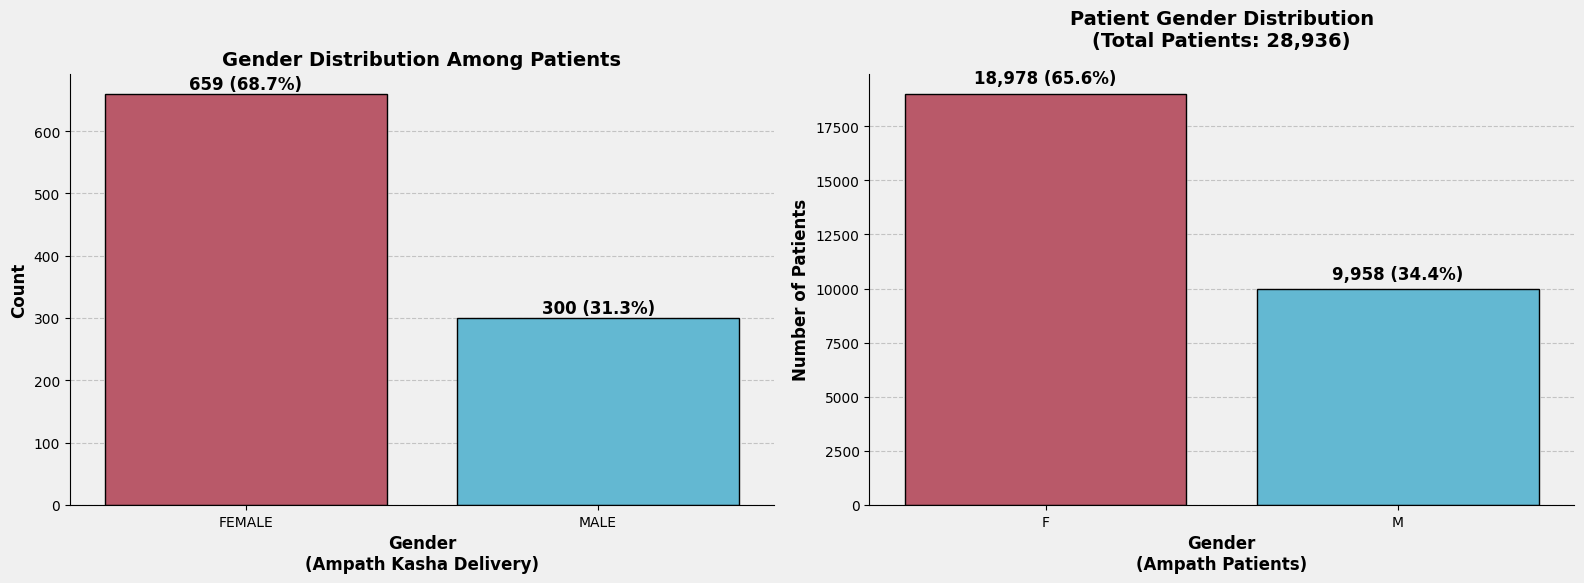

In [17]:
def plot_bar_chart(ax, df_ampath, column, title):
    data = df_ampath[column].value_counts().reset_index()
    data.columns = [column, "count"]

    color_pallette = {
        "FEMALE": "#C9495E",
        "MALE": "#50C2E5",
    }

    sns.barplot(
        x=column,
        y="count",
        hue=column,
        data=data,
        dodge=False,
        ax=ax,
        legend=False,
        palette=color_pallette,
        edgecolor="black",
    )

    total_count = len(df_ampath)

    # Adding value labels with percentages
    for p in ax.patches:
        count = int(p.get_height())
        percentage = (count / total_count) * 100
        ax.annotate(
            f"{count} ({percentage:.1f}%)",
            (p.get_x() + p.get_width() / 2, p.get_height() + 2),
            ha="center",
            va="bottom",
            fontsize=12,
            color="black",
            fontweight="bold",
        )

    ax.set_title(title, fontsize=14, fontweight="bold")
    ax.set_xlabel("Gender\n(Ampath Kasha Delivery)", fontsize=12, fontweight="bold")
    ax.set_ylabel("Count", fontsize=12, fontweight="bold")
    ax.grid(axis="y", linestyle="--", alpha=0.7)

    # Customize spines (remove the box look)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)


# Read data
df_ampath = read_file_ampath("data/Patient List.xlsx", sheet_name=0)
df = read_file_ampath_patient()

# Clean gender data and calculate counts and percentages
gender_counts = df.groupby("patient_identifier")["gender"].first().value_counts()
gender_percentages = gender_counts / gender_counts.sum() * 100
total_patients = gender_counts.sum()

# Create a figure with two subplots (side by side)
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# First bar chart: Gender Distribution in Ampath Data
plot_bar_chart(
    axes[0],
    df_ampath,
    "Customer Demographics Code",
    "Gender Distribution Among Patients",
)

# Second bar chart: Gender Distribution in Patient Data
color_pallette = {
        "F": "#C9495E",
        "M": "#50C2E5",
    }
sns.barplot(
    x=gender_counts.index,
    y=gender_counts.values,
    palette=color_pallette,
    edgecolor="black",
    ax=axes[1],
)

# Add value labels
for i, value in enumerate(gender_counts.values):
    axes[1].text(
        i,
        value + 500,
        f"{value:,} ({gender_percentages[i]:.1f}%)",
        ha="center",
        fontweight="bold",
        fontsize=12,
    )

axes[1].set_title(
    f"Patient Gender Distribution\n(Total Patients: {total_patients:,})",
    pad=20,
    fontsize=14,
    fontweight="bold",
)
axes[1].set_xlabel("Gender\n(Ampath Patients)", fontsize=12, fontweight="bold")
axes[1].set_ylabel("Number of Patients", fontsize=12, fontweight="bold")
axes[1].grid(axis="y", linestyle="--", alpha=0.7)
axes[1].spines["top"].set_visible(False)
axes[1].spines["right"].set_visible(False)

plt.tight_layout()
plt.show()


#### What the data shows:
 - The AMPATH patients program serves 28,936 patients. Women make up 65.6% of all patients. Different strategies for men and women may be needed to keep patients in care.
 - The AMPATH Kasha Delivery program serves 1,001 patients. The data shows that women constitute the majority, making up 68.1% of the total patient population. <br>

#### Similarities between the two datasets:
 1. Both datasets show that women constitute the largest population 

#### Questions:
**1. Why are women the largest population of patients?** <br>
**2. What factors (e.g., cultural, economic, or healthcare accessibility) could be contributing to the lower population of men?**

### Age Distribution Analysis - AMPATH Patient Dataset
This visualization shows the age breakdown of our 28,936 unique HIV patients, revealing important demographic patterns in our patient population.

<Figure size 1400x700 with 0 Axes>

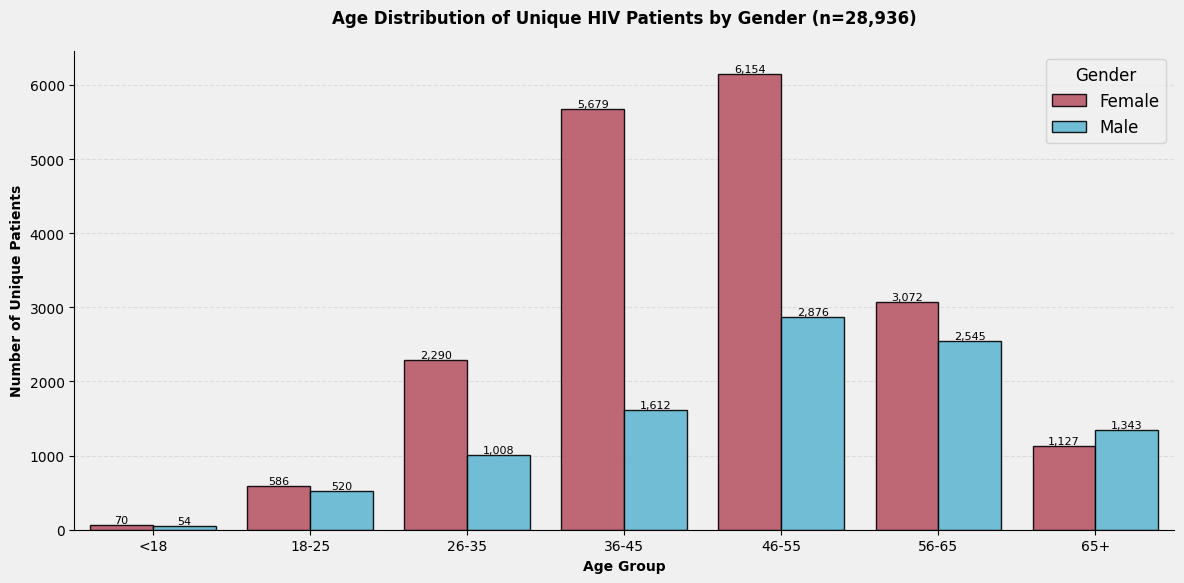

In [18]:
# Convert birthdate to datetime and calculate ages
df = read_file_ampath_patient()
df["birthdate"] = pd.to_datetime(df["birthdate"], errors="coerce")
df["age"] = (pd.Timestamp.now() - df["birthdate"]).dt.total_seconds() / (
    365.25 * 24 * 60 * 60
)

# Create age groups
df["age_group"] = pd.cut(
    df["age"],
    bins=[0, 18, 25, 35, 45, 55, 65, float("inf")],
    labels=["<18", "18-25", "26-35", "36-45", "46-55", "56-65", "65+"],
)

# Get unique patients by taking the first occurrence
unique_patients = df.drop_duplicates(subset="patient_identifier", keep="first")

# Calculate total unique patients
total_patients = len(unique_patients)

# Create the visualization
plt.figure(figsize=(14, 7))

# Define the color palette
colors = ["#C9495E", "#50C2E5"]
# colors=['#3498db', '#9b59b6']
# Create grouped bar plot
ax = sns.catplot(
    data=unique_patients,
    x="age_group",
    hue="gender",
    kind="count",
    palette=colors,
    edgecolor="black",
    height=6,
    aspect=2,
    alpha=0.9,
    order=["<18", "18-25", "26-35", "36-45", "46-55", "56-65", "65+"],
    legend=False,
)

plt.title(
    "Age Distribution of Unique HIV Patients by Gender (n=28,936)",
    pad=20,
    fontsize=12,
    fontweight="bold",
)
plt.xlabel("Age Group", fontsize=10)
plt.ylabel("Number of Unique Patients", fontsize=10)

# Add value labels with count only
for p in ax.ax.patches:
    count = int(p.get_height())
    ax.ax.annotate(
        f"{count:,}",
        (p.get_x() + p.get_width() / 2.0, p.get_height()),
        ha="center",
        va="bottom",
        fontsize=8,
    )

plt.grid(axis="y", linestyle="--", alpha=0.3)
plt.legend(title="Gender", loc="upper right", labels=["Female", "Male"])
plt.tight_layout()
plt.show()


### What the Data Shows
Looking at the age distribution:
- Middle-aged adults (46-55) form the largest group with 9,021 patients (31%)
- Strong representation in 36-45 age group with 7,304 patients (25%)
- Declining numbers in older age groups: 5,609 patients aged 56-65 (19%)
- Young adults (18-25) represent only 1,108 patients (4%)
- Very few pediatric patients (<18) with just 126 cases (<1%)
- Elderly patients (65+) account for 2,465 cases (9%)


**This age pattern suggests our HIV care program primarily serves middle-aged adults, with potential gaps in reaching younger populations. Data shows 63% of all new HIV infections in 2021 in Sub-Saharan Africa are adolescent girls and young women aged 15-24, why does our program show only 4% representation in this critical age group?**

**Hypothesis:**
**Many patients may have joined the program at a younger age (at the time of their first diagnosis) and have since aged into older categories over time.**

**To explore this, the next plot illustrates the age distribution of patients at the time of their first diagnosis. This will help us understand the age at which individuals are initially entering the program.**



### Age at First Diagnosis - AMPATH Patient Dataset

What was the age of patients when they were first diagnosed?

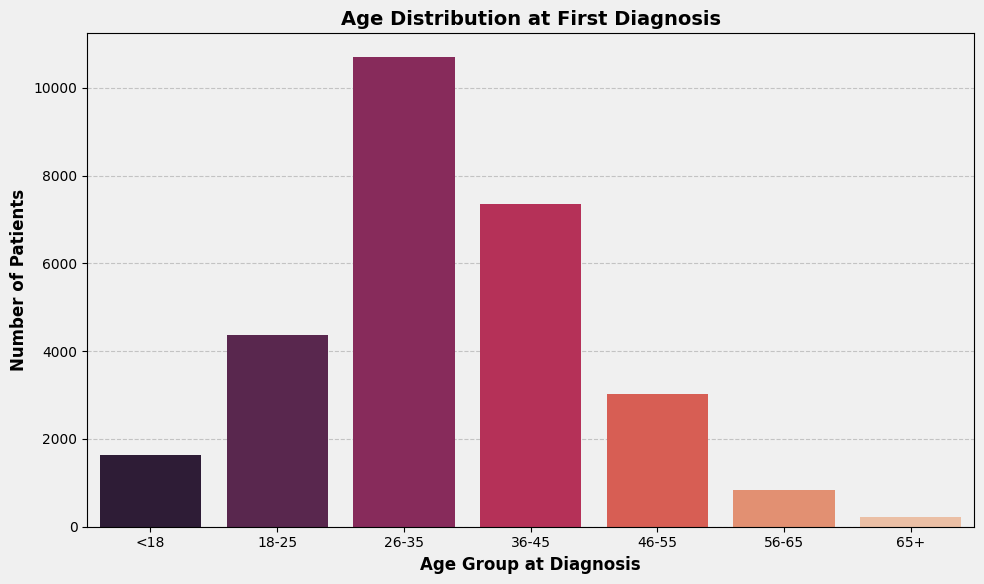

In [19]:
# Calculate age at first diagnosis
df["Diagnosis_Date"] = pd.to_datetime(df["Diagnosis_Date"], errors="coerce")
df["birthdate"] = pd.to_datetime(df["birthdate"], errors="coerce")

df["age_at_diagnosis"] = df["Diagnosis_Date"].dt.year - df["birthdate"].dt.year

# Get unique patient data
unique_patients = df.drop_duplicates(subset="patient_identifier", keep="first")

# Plot bar chart for age groups at diagnosis
age_bins = [0, 18, 25, 35, 45, 55, 65, float("inf")]
age_labels = ["<18", "18-25", "26-35", "36-45", "46-55", "56-65", "65+"]
unique_patients["age_group_at_diagnosis"] = pd.cut(
    unique_patients["age_at_diagnosis"], bins=age_bins, labels=age_labels
)

plt.figure(figsize=(10, 6))
sns.countplot(data=unique_patients, x="age_group_at_diagnosis", palette="rocket")
plt.title("Age Distribution at First Diagnosis", fontsize=14, fontweight="bold")
plt.xlabel("Age Group at Diagnosis", fontsize=12)
plt.ylabel("Number of Patients", fontsize=12)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

#### What the Data Shows:
Looking at the age distribution at first diagnosis:
 - The comulative number of patients in the age groups 18-25 and <18 is considerably lower than patients diagnosed in the age group of 26-35 and 36-45.
 - Age groups 26-35 and 36-45 have the highest number of patients at first diagnosis.
 - The older age groups record the lowest number of patients at first diagnosis.

#### Questions:
**1. What factors contribute to the strong representation in the 26-35 & 36-45 age groups?** <br>
**2. What factors contribute to the lower representation in the <18 & 18-25 age groups?**


### Age Range Distribution Analysis - AMPATH Kasha Delivery Dataset

This analysis illustrates the distribution of patients across different age groups.

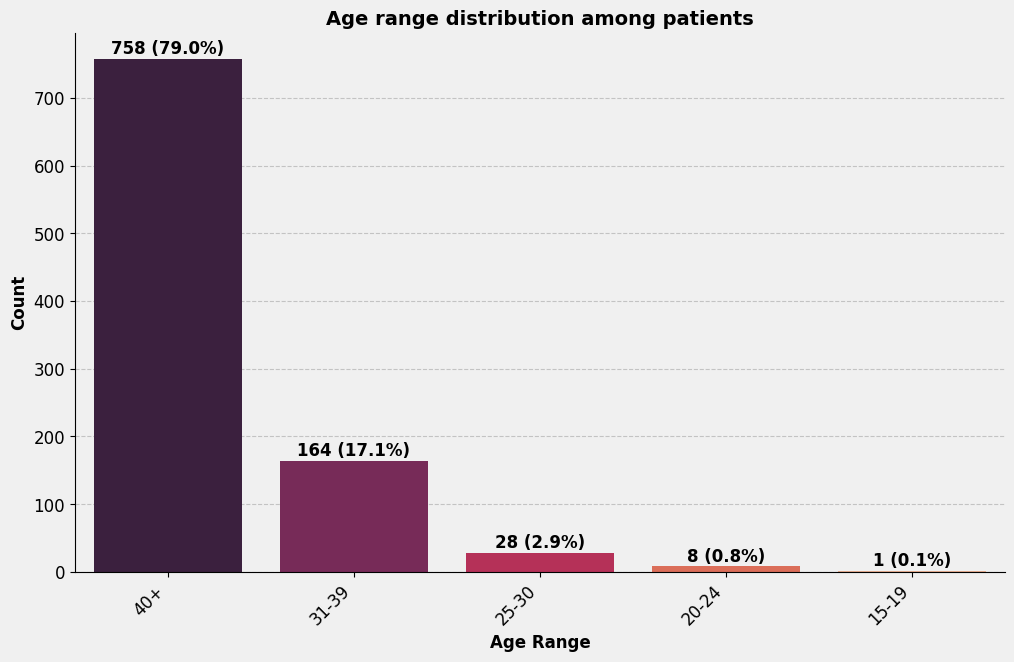

In [20]:
def plot_bar_chart(df_ampath, column, title):
    """Plots a bar chart for patient demographics with total counts and percentages."""
    plt.figure(figsize=(12, 7))
    data = df_ampath[column].value_counts().reset_index()
    data.columns = [column, 'count']
    
    color_pallette = {
    "40+": "#f28482",
    "31-39": "#84a59d",
    "15-19": "#f5cac3",
    "25-30": "#f7ede2",
    "20-24": "#f6bd60",
    }

    ax = sns.barplot(x=column, y='count', hue=column, data=data, dodge=False, legend=False, palette='rocket')

    total_count = len(df_ampath)

    # Customize spines (remove the box look)
    plt.gca().spines["top"].set_visible(False)
    plt.gca().spines["right"].set_visible(False)

    # Adding value labels with percentages
    for p in ax.patches:
        count = int(p.get_height())
        percentage = (count / total_count) * 100
        ax.annotate(f'{count} ({percentage:.1f}%)', 
                    (p.get_x() + p.get_width() / 2, p.get_height() + 2),
                    ha='center', va='bottom', fontsize=12, color='black', fontweight='bold')

    plt.xticks(rotation=45, ha='right', fontsize=12)
    plt.yticks(fontsize=12)
    plt.title(title, fontsize=14, fontweight='bold')
    plt.xlabel(column, fontsize=12, fontweight='bold')
    plt.ylabel('Count', fontsize=12, fontweight='bold')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()


if __name__ == "__main__":
    file_path = "data/Patient List.xlsx"
    sheet_name = 0  # Change if needed

    df_ampath = read_file_ampath(file_path, sheet_name)
    plot_bar_chart(df_ampath, "Age Range", "Age range distribution among patients")

#### What the data shows:
 - Older adults (40+ years) make up the majority of the patient population, accounting for 78.7% of the total count. <br>
 - Younger age groups (20-24 and below) represent the smallest segment, contributing less than 1% of the total patient count. <br>


#### Similarities between the two datasets:
1. The younger population (age group less than 25) make up the smallest population.
2. The population of the age group greater than 25 cumulatively make up the largest population in both datasets.

#### Questions:
**1. What could be the possible factors for the low representation of younger age groups in the patient population?** <br>

## Appendix

### Appendix A: Long Gaps Between Visits
This analysis looks at how consistently patients return for their follow-up visits. The charts show the time gaps between consecutive visits for all patients.


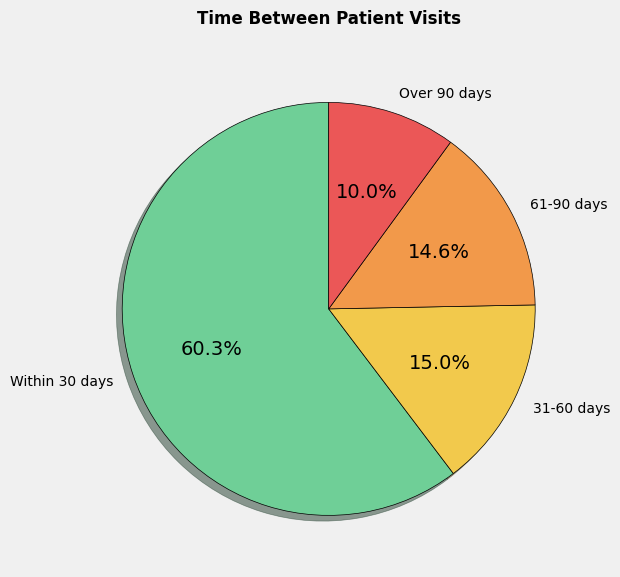

In [21]:
# Calculate days between visits for each patient
df = read_file_ampath_patient()
df_valid = df_valid.sort_values(["patient_identifier", "Encounter_Date"])
df_valid["days_to_next_visit"] = (
    df_valid.groupby("patient_identifier")["Encounter_Date"].diff().shift(-1).dt.days
)

# Create figure for the pie chart
fig, ax1 = plt.subplots(figsize=(8, 6))
plt.style.use("fivethirtyeight")

# Plot: Pie chart of visit gaps
gap_categories = pd.cut(
    df_valid["days_to_next_visit"],
    bins=[-float("inf"), 30, 60, 90, float("inf")],
    labels=["≤30 days", "31-60 days", "61-90 days", ">90 days"],
)
gap_proportions = gap_categories.value_counts(normalize=True) * 100


colors_pie = ["#6FCF97", "#F2C94C", "#F2994A", "#EB5757"]


# Plot: Pie chart with improved colors and labels
gap_labels = ["Within 30 days", "31-60 days", "61-90 days", "Over 90 days"]
ax1.pie(
    gap_proportions,
    labels=gap_labels,
    autopct="%1.1f%%",
    startangle=90,
    wedgeprops={"edgecolor": "black"},
    shadow=True,
    colors=colors_pie,
)
ax1.set_title("Time Between Patient Visits", pad=20, fontsize=12, fontweight="bold")

plt.tight_layout()
plt.show()


#### What the Data Shows
Looking at the visit patterns:
- Most visits (60.3%) happen within 30 days, showing good follow-up adherence
- 15% of visits occur between 31-60 days
- A concerning 24.6% of visits have gaps longer than 60 days:
  - 14.6% have gaps of 61-90 days
  - 10% have very long gaps exceeding 90 days

The bar chart reinforces this pattern:
- About 1.4 million visits follow regular patterns (≤60 days)
- Around 450,000 visits show concerning gaps (>60 days)
- A small number represent final recorded visits

**These patterns suggest that while most patients maintain regular visits, about 1 in 4 visits show gaps that could indicate risk of losing patients to follow-up. This presents an opportunity for early intervention to keep patients engaged in care.**

#### Questions:
**1. What are the common reasons for gaps longer than 60 days?**<br>
**2. What factors contribute to the strong follow-up adherence within 30 days for 60.3% of visits?**


### Appendix B: HIV Patient Registration Distribution

This analysis examines the distribution of patient registration dates for HIV treatment and services, grouped by month.


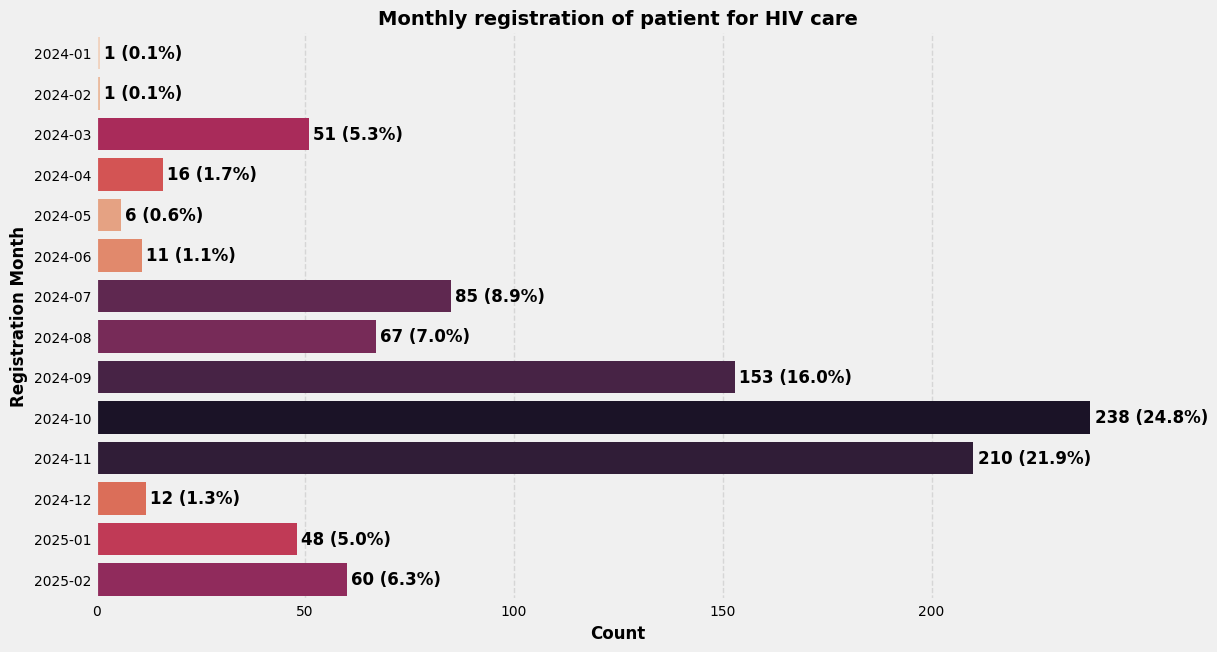

In [22]:
def plot_bar_chart(df_ampath, column, title, order=None):
    plt.figure(figsize=(12, 7))
    data = df_ampath[column].value_counts().reset_index()
    data.columns = [column, 'count']

    ax = sns.barplot(y=column, x='count', hue=column, data=data, dodge=False, legend=False, palette="rocket", order=order if order else data[column])

    total_count = data['count'].sum()

    # Customize spines (remove the box look)
    plt.gca().spines["top"].set_visible(False)
    plt.gca().spines["right"].set_visible(False)

    # Adding value labels with percentages
    for p in ax.patches:
        count = int(p.get_width())
        percentage = (count / total_count) * 100
        ax.annotate(f'{count} ({percentage:.1f}%)', 
                    (p.get_width() + 1, p.get_y() + p.get_height() / 2),
                    ha='left', va='center', fontsize=12, color='black', fontweight='bold')

    plt.ylabel(column, fontsize=12, fontweight='bold')
    plt.xlabel('Count', fontsize=12, fontweight='bold')
    plt.title(title, fontsize=14, fontweight='bold')
    plt.grid(axis='x', linestyle='--', alpha=0.7)
    plt.show()


def plot_date_consented_by_month(df_ampath, date_column):
    """Plots a horizontal bar chart showing the distribution of registration dates grouped by month in chronological order."""
    df_ampath[date_column] = pd.to_datetime(df_ampath[date_column], errors="coerce")
    df_ampath["Registration Month"] = (
        df_ampath[date_column].dt.to_period("M").astype(str)
    )
    month_order = sorted(df_ampath["Registration Month"].dropna().unique())

    plot_bar_chart(
        df_ampath,
        "Registration Month",
        "Monthly registration of patient for HIV care",
        order=month_order,
    )


if __name__ == "__main__":
    file_path = "data/Patient List.xlsx"
    sheet_name = 0  # Change if needed

    df_ampath = read_file_ampath(file_path, sheet_name)
    plot_date_consented_by_month(df_ampath, "Date Consented")

#### What the data shows:
 - The available data dates back to January 2024, providing a full-year view of registration trends.<br>
 - The highest patient registration rates occurred between September 2024 and November 2024, with October 2024 recording the peak at 24.8% of total registrations.<br>

#### Questions: 
1. **Why do we have lower registration dates in the last 3 months? What could be the cause of this?** <br>

### Conclusion
Looking at the analysis and the data points available, a POC would be possible to build. The dataset needs further cleaning and new data points have to be engineered from existing ones in the coming weeks that would be helpful in identifying LTFU. Here is a 3 step appraoch we can focus on to make the poc a success starting with buidling the models and using the results to make patient's lives better.

**Step 1: Monitor Visit Patterns**
- Track appointment adherence
- Analyze gaps between visits
- Identify seasonal attendance drops

**Step 2: Flag High-Risk Patients**
- Detect irregular visit patterns early
- Consider multiple risk factors
- Prioritize intervention cases

**Step 3: Targeted Interventions**
- Customize outreach strategies
- Provide additional support
- Follow up with at-risk patients

With 24.6% of visits showing concerning gaps (>60 days) and December consistently showing lower attendance, this system could help prevent loss to follow-up for many patients. 
**Note: This data analysis shows we have the feasibility of building a predictive model using existing visit data, appointment records, and patient characteristics to identify those at risk of dropping out of care.**